In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import tensorflow as tf
import torch
import numpy as np
import cv2
from imutils import perspective
import numpy as np
from skimage.filters import threshold_local
import imutils
from keras.models import load_model
import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from google.colab.patches import cv2_imshow

In [ ]:
best_path = "/content/drive/MyDrive/Machine_Learning/best.pt"
model_detect_frame = torch.hub.load('ultralytics/yolov5', 'custom', path=best_path, force_reload=True)
model_detect_text = load_model("/content/drive/MyDrive/Machine_Learning/Model_KyTu.h5", compile=False)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-12-18 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
BienSo summary: 182 layers, 7246518 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    ii = cv2.imread('contours.jpg')
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy)
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)
    return img_res

In [ ]:
def segment_characters(image):
    img_lp = cv2.resize(image, (300, 95))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:10,:] = 255
    img_binary_lp[:,0:30] = 255
    img_binary_lp[93:95,:] = 255
    img_binary_lp[:,265:333] = 255
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contours.jpg',img_binary_lp)
    char_list = find_contours(dimensions, img_binary_lp)
    return char_list

In [ ]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHKLMNPRSTUVXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char):
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model_detect_text.predict(img)
        y_ = np.argmax(y_, axis=1)
        x=y_[0]
        print(y_)
        output.append(characters[x])

    plate_number = ''.join(output)

    return plate_number

In [ ]:
def getPlateTextFromImage(imgPath):
    image = cv2.imread(imgPath)
    results = model_detect_frame(image)
    df = results.pandas().xyxy[0]
    for obj in df.iloc:
        xmin = float(obj['xmin'])
        xmax = float(obj['xmax'])
        ymin = float(obj['ymin'])
        ymax = float(obj['ymax'])
    coord = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
    LpRegion = perspective.four_point_transform(image, coord)
    image = LpRegion.copy()
    Hang = cv2.resize(image, (300, 300),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
    Tren=Hang[0:160, 0:300]
    Duoi=Hang[140:300, 0:300]
    char1 = segment_characters(Tren)
    char2 = segment_characters(Duoi)
    a = (show_results(char1))
    b = (show_results(char2))
    print('Bien so xe la:')
    print(str(a))
    print(str(b))
    return

=======================================TEST=======================================

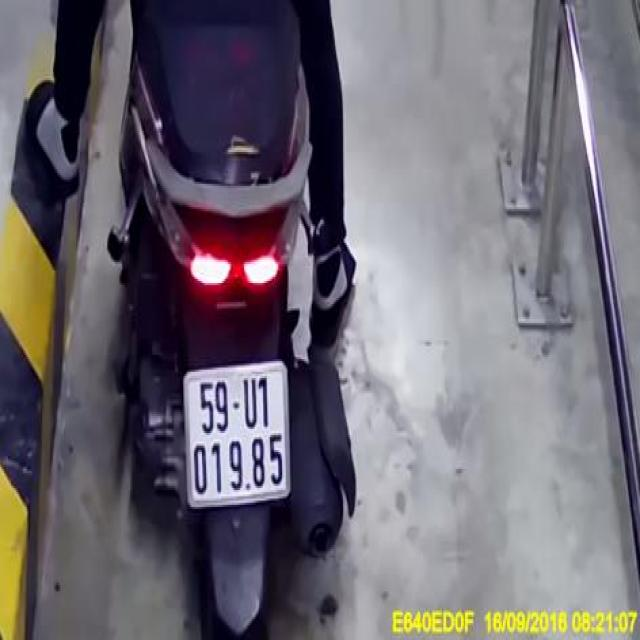

In [ ]:
img=cv2.imread('/content/drive/MyDrive/Machine_Learning/Data/BienSo/valid/images/0121_00820_b_jpg.rf.679d1d8ba09b0c7270a68586e56cefe4.jpg')
cv2_imshow(img)

In [ ]:
getPlateTextFromImage('/content/drive/MyDrive/Machine_Learning/Data/BienSo/valid/images/0121_00820_b_jpg.rf.679d1d8ba09b0c7270a68586e56cefe4.jpg')

1/1 [==============================] - 0s 337ms/step
[5]
1/1 [==============================] - 0s 43ms/step
[9]
1/1 [==============================] - 0s 40ms/step
[26]
1/1 [==============================] - 0s 40ms/step
[1]
1/1 [==============================] - 0s 41ms/step
[0]
1/1 [==============================] - 0s 47ms/step
[1]
1/1 [==============================] - 0s 45ms/step
[9]
1/1 [==============================] - 0s 47ms/step
[8]
1/1 [==============================] - 0s 39ms/step
[5]
Bien so xe la:
59U1
01985


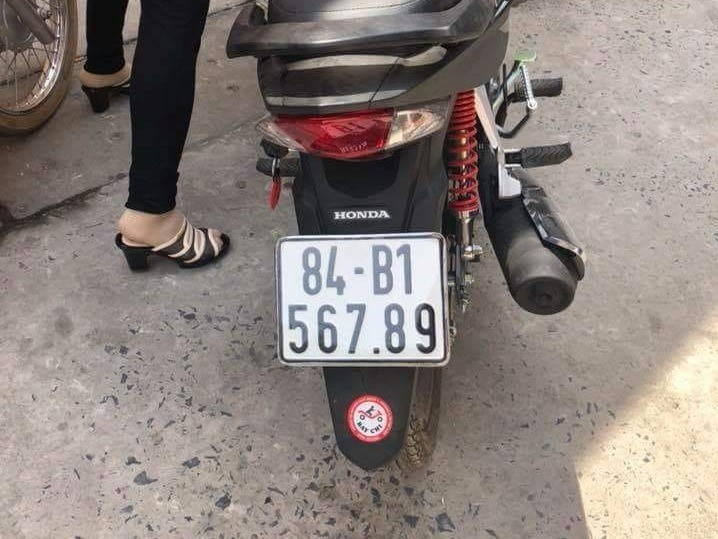

In [ ]:
img=cv2.imread('/content/drive/MyDrive/Co-duoc-gan-bien-so-xe-may-o-phia-truoc-xe-hay-khong-2.jpg')
cv2_imshow(img)

In [ ]:
getPlateTextFromImage('/content/drive/MyDrive/Co-duoc-gan-bien-so-xe-may-o-phia-truoc-xe-hay-khong-2.jpg')

1/1 [==============================] - 0s 41ms/step
[8]
1/1 [==============================] - 0s 43ms/step
[4]
1/1 [==============================] - 0s 41ms/step
[11]
1/1 [==============================] - 0s 39ms/step
[1]
1/1 [==============================] - 0s 38ms/step
[5]
1/1 [==============================] - 0s 42ms/step
[6]
1/1 [==============================] - 0s 38ms/step
[7]
1/1 [==============================] - 0s 42ms/step
[8]
1/1 [==============================] - 0s 53ms/step
[9]
Bien so xe la:
84B1
56789
